In [204]:
from collections import Counter
from itertools import chain
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk import pos_tag, ne_chunk, Tree
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

## Data Preparation

In [107]:
bipolar_df = pd.read_csv('../data/RedditBipolar.csv', encoding='latin9', delimiter=';', parse_dates=['date'])
bipolar_df = bipolar_df[['date', 'author', 'post']]
bipolar_df.head()

,date,author,post
0,01/01/2018,TanagerOffTrack,What birth control are you on? I tried an IUD ...
1,01/01/2018,DuplicitousSnake,Hypersexuality I was diagnosed with bipolar un...
2,01/01/2018,dearangelou,Meditation I have been using the free meditati...
3,01/01/2018,dootdoopdooq,Family question diagnosis - vent Start with th...
4,01/01/2018,lemonyellow3,Unable to stop talking to myself- any ideas/ex...


In [108]:
print(bipolar_df.shape)
print(bipolar_df['post'].nunique())
print(bipolar_df['author'].nunique())
print(bipolar_df.info())

(1692, 3)
1692
1618
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1692 non-null   object
 1   author  1692 non-null   object
 2   post    1692 non-null   object
dtypes: object(3)
memory usage: 39.8+ KB
None


## Text Preprocessing

### Tokenization

In [109]:
bipolar_df['post_tokens_uppercase'] = bipolar_df['post'].apply(lambda x: nltk.word_tokenize(x))



### Stop word removal

In [110]:
stop_words = stopwords.words('english')

bipolar_df['post_tokens_lowercase'] = bipolar_df['post_tokens_uppercase'].apply(
  lambda x: [word.lower() for word in x if word.lower().isalpha() and word.lower() not in stop_words]
)

### POS tagging

In [111]:
bipolar_df['post_tokens_uppercase_with_pos_tags'] = bipolar_df['post_tokens_uppercase'].apply(pos_tag)

### Named entity recognition

In [112]:
def extract_named_entities(tree):
  entities = []
  for node in tree:
    if isinstance(node, Tree): # instance of nameed entity
      entity_type = node.label()
      entity_words = " ".join(word for word, _ in node.leaves())
      entities.append((entity_words, entity_type))
  return entities

In [123]:
bipolar_df['named_entities'] = bipolar_df['post_tokens_uppercase_with_pos_tags'].apply(
    lambda tagged: extract_named_entities(ne_chunk(tagged))
)


### Lemmatization

In [114]:
def map_pos_tags(tag: str):
  if tag.startswith('J'):
      return 'a'
  elif tag.startswith('V'):
      return 'v'
  elif tag.startswith('R'):
      return 'r'
  return 'n'

In [126]:
wnl = WordNetLemmatizer()

bipolar_df['post_lemmas_lowercase'] = bipolar_df['post_tokens_lowercase'].apply(lambda x: [wnl.lemmatize(word) for word in x])

bipolar_df['post_lemmas_uppercase'] = bipolar_df['post_tokens_uppercase_with_pos_tags'].apply(
  lambda tagged: [wnl.lemmatize(word=word, pos=map_pos_tags(tag)) for word, tag in tagged]
)

## Exploratory Analysis

### Word frequency analysis

In [137]:
all_lemmas = list(chain.from_iterable(bipolar_df['post_lemmas_lowercase']))
word_count = Counter(all_lemmas)

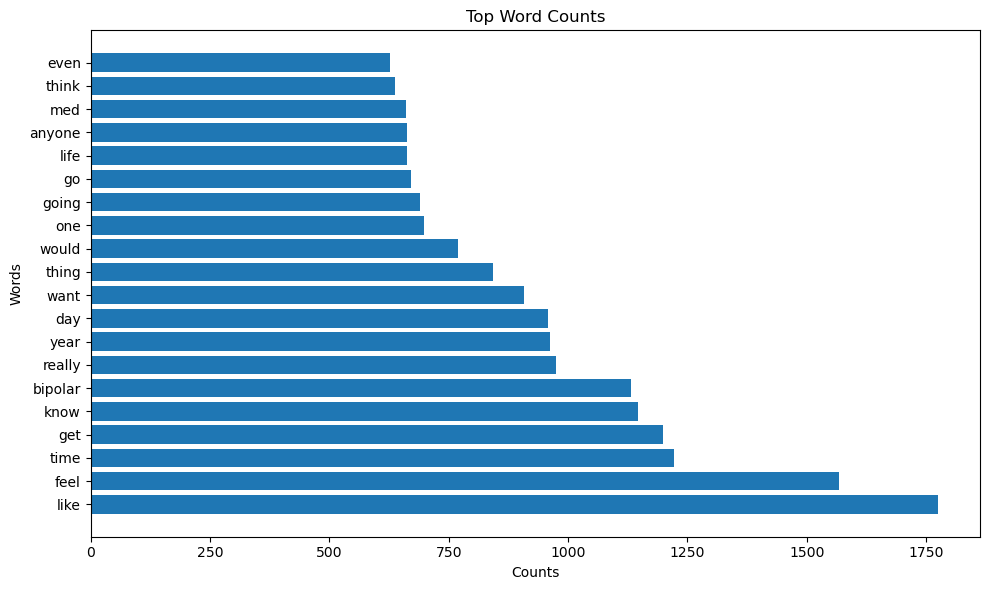

In [138]:
top_words = word_count.most_common(20)

words, counts = zip(*top_words)

plt.figure(figsize=(10, 6))
plt.barh(words, counts)
plt.title('Top Word Counts')
plt.xlabel('Counts')
plt.ylabel('Words')
plt.tight_layout()
plt.show()

### Word clouds

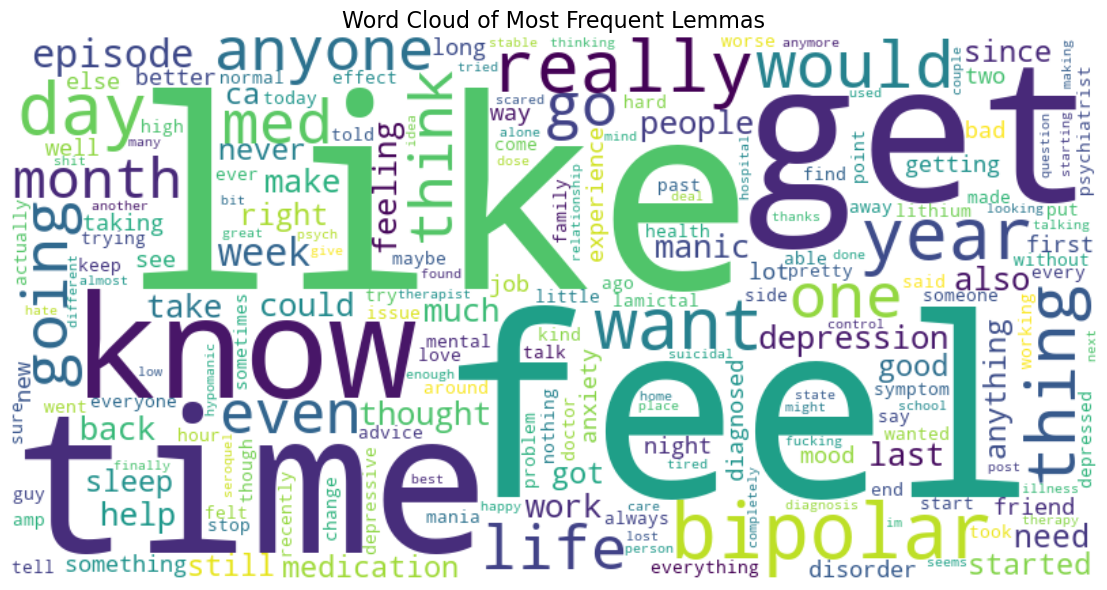

In [149]:
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_count)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Frequent Lemmas", fontsize=16)
plt.tight_layout()
plt.show()

### Top entities overall

In [153]:
all_entities = list(chain.from_iterable(bipolar_df['named_entities']))
all_entities = [word for word, _ in all_entities]
entity_counts = Counter(all_entities)

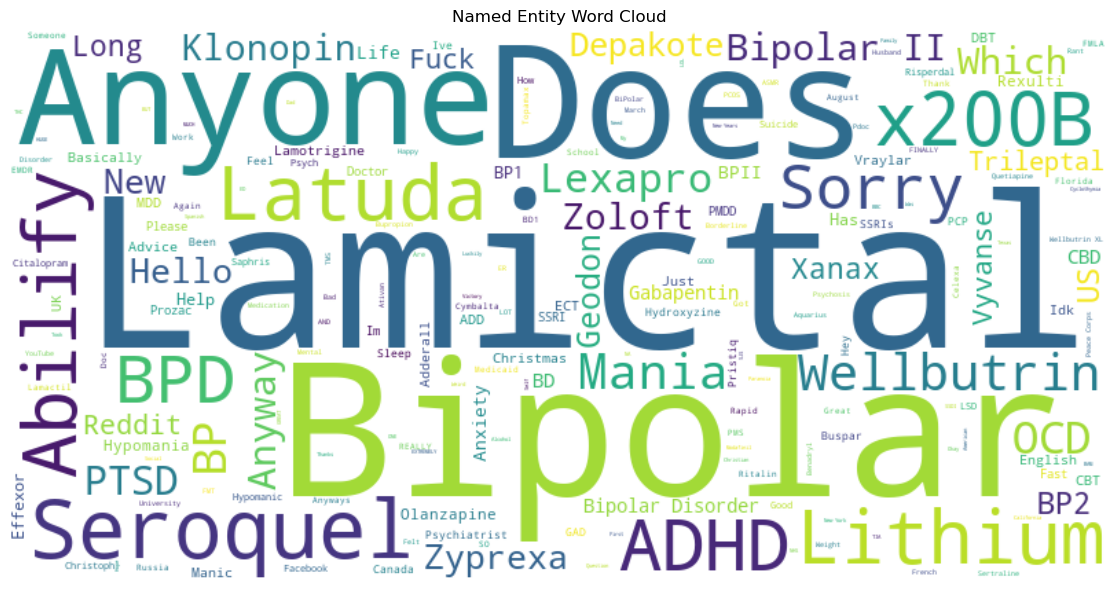

In [155]:
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(entity_counts)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.title('Named Entity Word Cloud')
plt.axis('off')
plt.tight_layout()
plt.show()

### Sentiment analysis

In [166]:
bipolar_df = bipolar_df.drop(['compound', 'pos', 'neg', 'neu'], axis=1)

In [ ]:
sia = SentimentIntensityAnalyzer()

# generates a dictionary of normalized scores (neg, neu, pos, compound)
bipolar_df['sentiment'] = bipolar_df['post'].apply(sia.polarity_scores)

# creates a dataframe from json
sentiment_df = pd.json_normalize(bipolar_df['sentiment'])

# concatenates the bipolar_df and sentiment_df columns
bipolar_df = pd.concat([bipolar_df, sentiment_df], axis=1)

0      -0.9890
1       0.6634
2       0.9274
3      -0.9932
4      -0.8014
         ...  
1687    0.9976
1688   -0.9419
1689   -0.9247
1690   -0.9764
1691   -0.1027
Name: compound, Length: 1692, dtype: float64

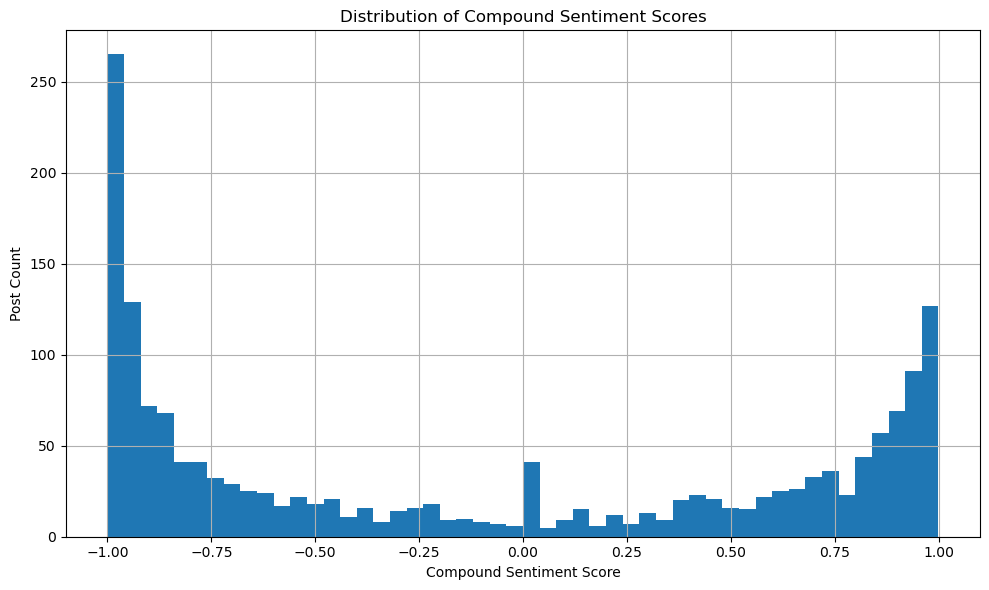

In [168]:
plt.figure(figsize=(10, 6))
plt.hist(bipolar_df['compound'], bins=50)
plt.title('Distribution of Compound Sentiment Scores')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Post Count')
plt.grid(True)
plt.tight_layout()
plt.show()

In [172]:
def label_sentiment(x: float):
  if x <= -0.05:
    return 'Negative'
  if x >= 0.05:
    return 'Positive'
  return 'Neutral'

bipolar_df['sentiment_label'] = bipolar_df['compound'].apply(label_sentiment)
bipolar_df['sentiment_label'].value_counts(normalize=True)

sentiment_label
Negative    0.543735
Positive    0.427305
Neutral     0.028960
Name: proportion, dtype: float64

## Topic Modeling

### TF-IDF matrix

In [199]:
def lemmas_to_string(lemmas: list[str]):
  return ' '.join(lemma for lemma in lemmas)

bipolar_df['post_lemma_string_lowercase'] = bipolar_df['post_lemmas_lowercase'].apply(lemmas_to_string)

tfidf_vectorizer = TfidfVectorizer(
  ngram_range=(2, 3),
  min_df=5,
  max_df=0.95,
  stop_words='english'
)

X_tfidf = tfidf_vectorizer.fit_transform(bipolar_df['post_lemma_string_lowercase'])

### Non-Negative Matrix Factorization (NMF)

In [201]:
n_components = 10

model = NMF(
  n_components=n_components,
  init='random',
  random_state=42,
  max_iter=1000
)

W = model.fit_transform(X_tfidf) # document-topic matrix → each row shows how much each topic contributes to a post
H = model.components_ # topic-term matrix → each row is a topic, each column a term

In [202]:
feature_names = tfidf_vectorizer.get_feature_names_out() # Gets the words from the tf-idf vector

for topic_idx, topic in enumerate(H): # for loop to map the top columns in the H matrix to their corresponding words in the feature_names
  top_indices = topic.argsort()[::-1][:10] # reverse sort the top ten indices according to their topic weights
  top_words = [feature_names[i] for i in top_indices] # retrieve the feature names for the top ten indices
  print(f'Topic {topic_idx+1}: {", ".join(top_words)}') # print the n-grams corresponding to each topic

Topic 1: feel like, make feel, like going, make feel like, feeling like, feel like going, time feel, time feel like, wan na, dont know
Topic 2: year ago, similar experience, diagnosed year, diagnosed year ago, year old, mixed episode, past year, bipolar year ago, bipolar year, taking med
Topic 3: mental health, mental illness, health issue, mental health issue, http http, hey guy, depression anxiety, lot different, health care, quality life
Topic 4: new year, year year, day ago, make sure, good vibe, suicidal depression, say thing, pretty good, feeling like, going doctor
Topic 5: bipolar disorder, diagnosed bipolar disorder, people bipolar, bipolar disorder year, mental illness, disorder year, living bipolar, people bipolar disorder, family member, know bipolar
Topic 6: depressive episode, rapid cycling, bad depressive episode, bad depressive, weight gain, episode know, mixed episode, really really, greatly appreciated, hypomanic episode
Topic 7: month ago, felt like, started taking, p

### LDA

In [205]:
count_vectorizer = CountVectorizer(
  ngram_range=(2, 3),
  min_df=5,
  max_df=0.95,
  stop_words='english'
)

X_count = count_vectorizer.fit_transform(bipolar_df['post_lemma_string_lowercase'])

In [207]:
n_components = 10

lda = LatentDirichletAllocation(
  n_components=n_components,
  random_state=42,
  max_iter=1000
)

lda.fit(X_count)

,n_components,10
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,1000
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


In [212]:
feature_names = count_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
  top_indices = topic.argsort()[::-1][:10]
  top_words = [feature_names[i] for i in top_indices]
  print(f'Topic {topic_idx + 1}: {", ".join(top_words)}')

Topic 1: feel like, month ago, suicidal thought, manic episode, year half, make feel, started taking, past week, racing thought, like going
Topic 2: dont know, day day, taking med, mood stabilizer, getting worse, med change, self harm, know going, think going, work know
Topic 3: feel like, mental health, panic attack, long time, felt like, depressive episode, manic episode, time feel, make feel, taking lithium
Topic 4: depressive episode, rapid cycling, look like, manic episode, health insurance, felt like, day ago, bipolar disorder, new job, little bit
Topic 5: feel like, feeling like, diagnosed bipolar, manic phase, like feel, make feel, stopped taking, psychotic episode, time really, mixed state
Topic 6: feel like, birth control, depressive episode, manic episode, mental health, make sense, wan na, new year, year old, time year
Topic 7: bipolar disorder, diagnosed bipolar, manic episode, year ago, diagnosed bipolar disorder, recently diagnosed, mood stabilizer, disorder year, bipola

## Clustering and Classification

### Group posts by linguistic similarity

### KMeans clustering

### DBSCAN

### Classify posts by manic or depressive tone